In [1]:
import glob 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from fastpip import pip
from scipy.signal import savgol_filter    
import scipy
from scipy.optimize import curve_fit

# Preliminar analysis

In this script, I will try to put everything togheder to compute the transition among state ABAB to AAAA obtained by changing the magnetic interaction among particles from purely repulsive to purely attractive. How the magnetic field change in each experiment is explained and computed in script Setting_MagneticField.ipynb. 

In this preliminar analysis I will analyze Experiment 0. This experiment correspond with a purelly attractive interaction. 

To do:

    1. Choose interaction cut off, to separate "train" of particles. 
        Solved: Instead of trains of particles I will analyze pairs of particles.
    2. Develop algorith to define magnetization.
    3. Choose criterium for "density" in trains, the particle-particle distances are not constant.
        Solved: I will choose the mean distance among particles. 
    

## 1. 
The interaction cut off will be obtained from the magnetic susceptibility calculation. At 21 mT the particles reach a maximum distance of approx 70 $\mu m$. The size of the particles is 18.82 $\mu m$.

  <span style="color:red">To do: Take an image of scale bar with 10x Objective!</span>

## 2. 
To do that I need to have the tracking trajectories

    Solved: Trajectories obtained in Script Automatic_Tracking

In [2]:
directory = "/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments"

filenames = [file for file in glob.glob(
    os.path.join(directory,('*_tracking.dat')))]
filenames

['/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP6_2023_03_23_16_41_46_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP9_2023_03_23_16_16_55_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP8_2023_03_23_16_23_59_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP9_2023_03_23_16_13_44_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP7_2023_03_23_16_31_57_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP9_2023_03_23_16_12_21_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/wi

In [3]:
# for file_no, filename in enumerate(filenames[0:]):

#     trj = pd.read_csv(filename[:filename.find("_tracking.dat")]+"_tracking.dat", index_col = [0,1], sep ="\t")

In [4]:
name = 'EXP6_2023_03_23_16_39_23'

In [5]:
trj = pd.read_csv(os.path.join(directory,(name+'_tracking.dat')),sep = '\t', usecols = ['frame','particle','x','y'])

In [6]:
n_of_particles = len(trj['particle'].unique())
n_of_particles, trj['particle'].unique()

(34,
 array([  1,   2,   4,   6,  10,  11,  12,  13,  14,  17,  27,  29,  30,
         34,  35,  36,  37,  38,  40,  41,  43,  44,  45,  47,  48,  49,
         50,  52,  54,  55,  56,  57,  59, 644]))

# Checking tracking

In [7]:
# trj = trj.query('frame < 3600')

/home/carolina/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


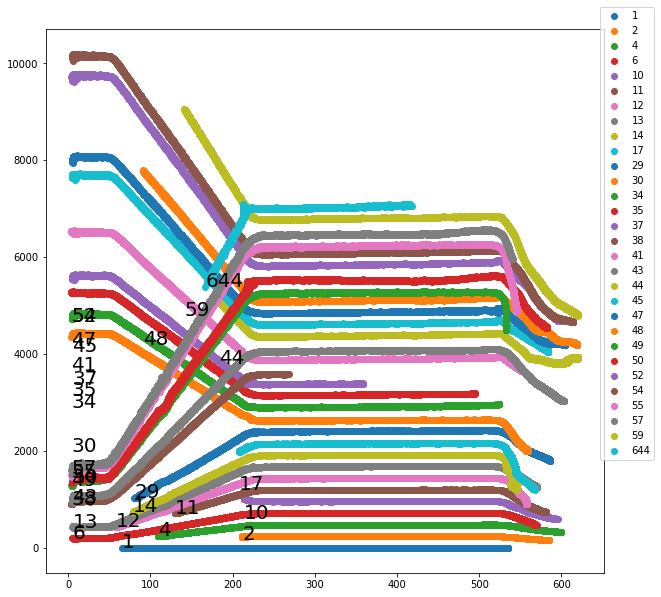

In [37]:
fig, ax = plt.subplots(1, figsize = (10,10))
i = 0
for p, gr in trj.groupby('particle'):
    
    plt.plot(gr.x, gr.y*i, 'o', label = p)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.text(gr.x.min(), gr.y.min()*i, s = str(p), size = 20)
    
    i = i+1

In [36]:
trj = trj[trj.particle != 56] # To drop unuseful particles

In [38]:
n_of_particles = len(trj['particle'].unique())
n_of_particles, trj['particle'].unique()

(30,
 array([  1,   2,   4,   6,  10,  11,  12,  13,  14,  17,  29,  30,  34,
         35,  37,  38,  41,  43,  44,  45,  47,  48,  49,  50,  52,  54,
         55,  57,  59, 644]))

# Functions used during analysis

In [39]:
def y_bifurcation_position(df):
    """In this function I will locate the bifurcation position"""
    
    y, x , _ = plt.hist(df['y'], bins = 40, )
    y_bif = x[np.argmax(y)]
    
    return y_bif, df

def x_bifurcation_position(df, y_bif):
    """In this function I will find the x value of the bifurcation"""
    
    particles = df.particle.unique()
    points = []
    for i in particles:
        
        particle = trj.query('particle =='+str(i))

        data = np.stack((particle.x, particle.y), axis=-1)
        points.append(pip(data,4))
    
    points_ar = np.array(points)
    new_df = points_ar.reshape((len(points_ar[0])*len(points_ar),2))
    df = pd.DataFrame(data=new_df, columns = ['x', 'y'])
    y_bifurcation_plus = y_bif+10
    y_bifurcation_minus = y_bif-10

    df_filtered = df.query('y < '+str(y_bifurcation_plus)+' & y > '+str(y_bifurcation_minus))
    x_bif = df_filtered.x.min()
    return x_bif

In [40]:
def improve_x_and_y_bif(trj, x_bif, y_bif):
    
    """This function will improve the first estimation of x_bif and y_bif
        and will return a fit of the channel"""
    x_int = []
    y_int = []
    fit=[]
    
    for i in range(0,len(trj['particle'].unique())):
        
        particle = trj['particle'].unique()[i] # Select a particle trj
        
        print(particle)

        x1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).x
        y1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).y

        x2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).x
        y2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).y
            
        fit1 = np.poly1d(np.polyfit(x1, y1, 1)) # fit biburcation
        fit2 = np.poly1d(np.polyfit(x2, y2, 1)) # fit channel

        fit.append(np.poly1d(np.polyfit(x2, y2, 1))) # fit channel
        # compute intersection among fits
        x_int.append((fit2[0]-fit1[0])/(fit1[1]-fit2[1]))
        y_int.append(fit1[1]*x_int[i]+fit1[0])
        
    x_int = np.mean(x_int)
    y_int = np.mean(y_int)
    
    return x_int, y_int, fit

In [41]:
def up_or_down(df, y_bif):
    
    """This function indicates which channel the particle has choose.
    The information is stored in the column bif."""
    
    df_trj = df[df.duplicated(subset=['frame'], keep=False)]  # Keep only frames that have more than one particle

    df_trj['bif'] = np.NaN
    for p,df in df_trj.groupby('particle'):
        
        if df.iloc[-1].y > y_bif:
            df_trj.loc[trj.particle==p,'bif'] = 'UP'
        else:
            df_trj.loc[trj.particle==p,'bif']= 'DOWN'
        
    return df_trj

In [42]:
def create_pairs(df, frame):
    """This function generates pair of particles. A pair of particle is defined 
    when one particles enter to the channel after the other. So, consecutive
    particles will be part of a pair.
    This function works for one frame"""

    df_f = df.query('frame == '+str(frame)) # First select a frame

    df_order = df_f.sort_values(by = ['x'])       # Order the x column in ascendent values, 
                                                  # this will be the order of particles entering the chanel. 
    new_df = []
    keys = []
    p1 = []
    p2 = []
    j = 2
    
    for i in range(0, len(df_order)-1):       
        
        p1.append(df_order.iloc[i:j].particle.values[0])
        p1.append(df_order.iloc[i:j].particle.values[0])


        p2.append(df_order.iloc[i:j].particle.values[1])
        p2.append(df_order.iloc[i:j].particle.values[1])

        new_df.append(df_order.iloc[i:j])  # Join consecutive rows, generating pairs
      

        keys.append(i)
        j = j +1
    p1 = pd.DataFrame({'p1':p1})
    p2 = pd.DataFrame({'p2':p2})

    final_df = pd.concat(new_df, keys = keys, names = ['pairs','index'])
    pairs = pd.concat([p1,p2], axis = 1)
    
    final_df['p1'] = pairs['p1'].values
    final_df['p2'] = pairs['p2'].values
    
    return final_df

In [43]:
def magnetization(df, frame):
    
    """Magnetization is equal to 1 when the 2 particles choose the same channel
        Magnetization is equal to 0 when the particles choose different channels"""
    
    df = df.query('frame == '+str(frame))
    magnetization = []
    for ind,group in df.groupby(['pairs']):

        if len(np.unique(group.bif)) == 2:

            magnetization.append(0)
            magnetization.append(0)

        else:

            magnetization.append(1) 
            magnetization.append(1)


    df['magnetization'] = magnetization
    return df

In [44]:
def d(df , pix = float, um = float):  
    "With this function I will compute the distance among particles."
    
    df['distance'] = np.NaN # Crate new column
    d = []
    grouped = df.groupby(['frame','pairs'])
    for name,group in grouped:
        
        d.append((np.sqrt((group.x.diff(periods=-1).values)**2 + (group.y.diff(periods=-1).values)**2)[0])*(um/pix))
        d.append((np.sqrt((group.x.diff(periods=-1).values)**2 + (group.y.diff(periods=-1).values)**2)[0])*(um/pix))
    
    df['distance'] = d
    
    return df

In [45]:
def check_analysis(trj_initial,last_df_analyzed):
    
    n_of_particles = len(trj_initial['particle'].unique())
    n_of_pairs = len(last_df_analyzed.groupby(['p1','p2']).size())
    
    if (n_of_particles == n_of_pairs+1):
        
        print("Analysis succesfully performed of video")
    else:
        print("Something was wrong during tracking or analysis. We detect N partcles and not N-1 pairs")

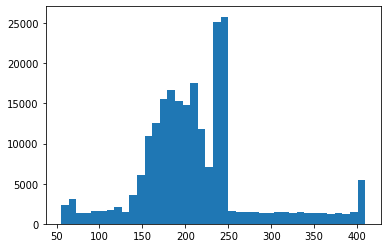

In [46]:
y_bif, df = y_bifurcation_position(trj)
x_bif = x_bifurcation_position(trj, y_bif)

In [47]:
x_bif

214.47817836812146

In [48]:
x_bif, y_bif, fit = improve_x_and_y_bif(trj,x_bif, y_bif)


1
2
4
6
10
11
12
13
14
17
29
30
34
35
37
38
41
43
44
45
47
48
49
50
52
54
55
57
59
644


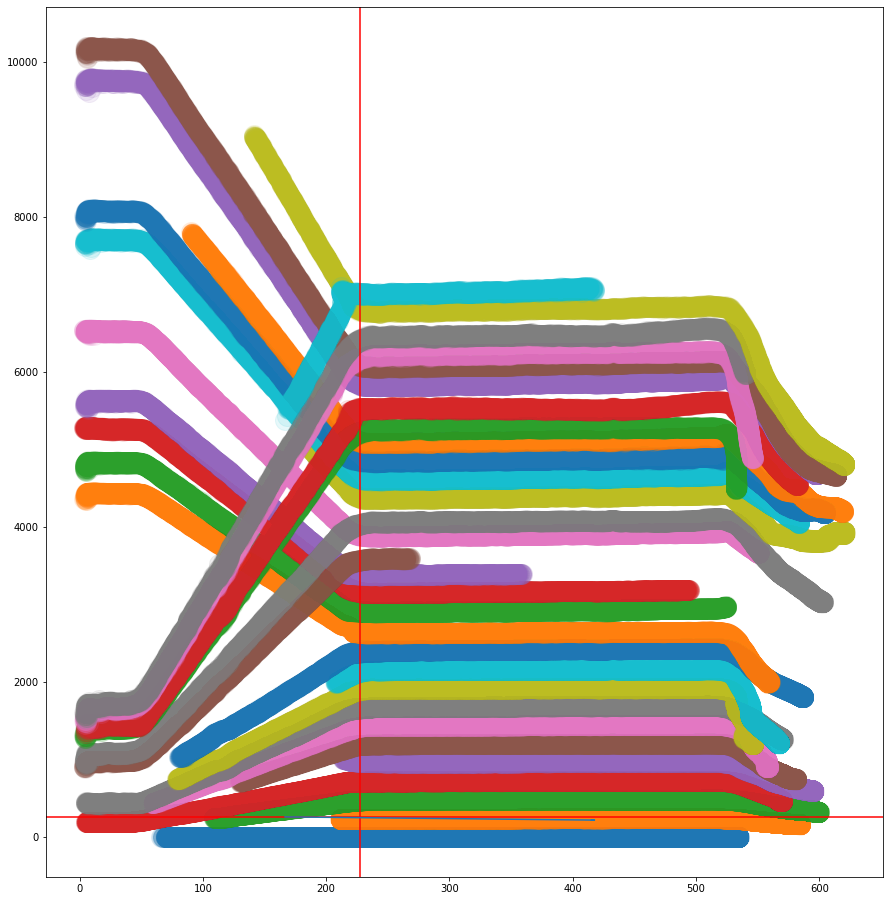

In [49]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in trj.groupby("particle"):
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [50]:
fit

[poly1d([-1.63968856e-01,  2.89914528e+02]),
 poly1d([-2.32732357e-01,  3.18723613e+02]),
 poly1d([-2.30656170e-01,  3.18612729e+02]),
 poly1d([-2.33902040e-01,  3.16258216e+02]),
 poly1d([-2.96996271e-01,  3.40166662e+02]),
 poly1d([-2.78749164e-01,  3.28502002e+02]),
 poly1d([-2.66927658e-01,  3.27087096e+02]),
 poly1d([-1.48844996e-01,  2.85442403e+02]),
 poly1d([-2.64907229e-01,  3.26190941e+02]),
 poly1d([-3.37450795e-01,  3.49957617e+02]),
 poly1d([-1.67501075e-01,  2.94904940e+02]),
 poly1d([-1.45980275e-01,  2.85138082e+02]),
 poly1d([1.13475975e-02, 2.39579413e+02]),
 poly1d([3.96610918e-03, 2.42464743e+02]),
 poly1d([-1.60322638e-03,  2.42565736e+02]),
 poly1d([8.53250939e-02, 2.17874798e+02]),
 poly1d([-1.32818236e-02,  2.48096991e+02]),
 poly1d([-1.74620221e-01,  2.99267422e+02]),
 poly1d([-1.03372821e-01,  2.77923345e+02]),
 poly1d([-6.83875677e-02,  2.67107489e+02]),
 poly1d([-1.09051720e-01,  2.81166366e+02]),
 poly1d([-1.43723298e-01,  2.95754035e+02]),
 poly1d([-7.2736

In [51]:
inter = up_or_down(trj,y_bif)

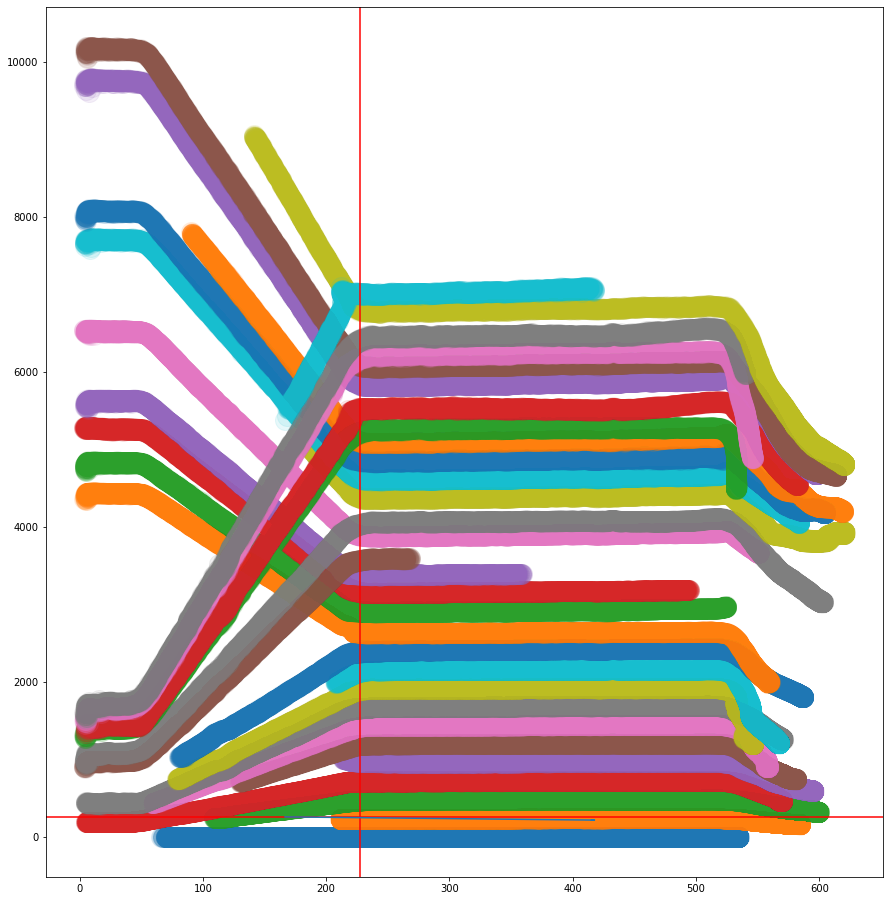

In [52]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in inter.groupby("particle"):
    
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [53]:
len(trj), len(inter)

(229004, 229004)

In [54]:
df_x = inter.query('x > '+str(x_bif))
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

In [55]:
len(df_x), len(df_d)

(156090, 156041)

1
2
4
6
10
11
12
13
14
17
29
30
34
35
37
38
41
43
44
45
47
48
49
50
52
54
55
57
59
644


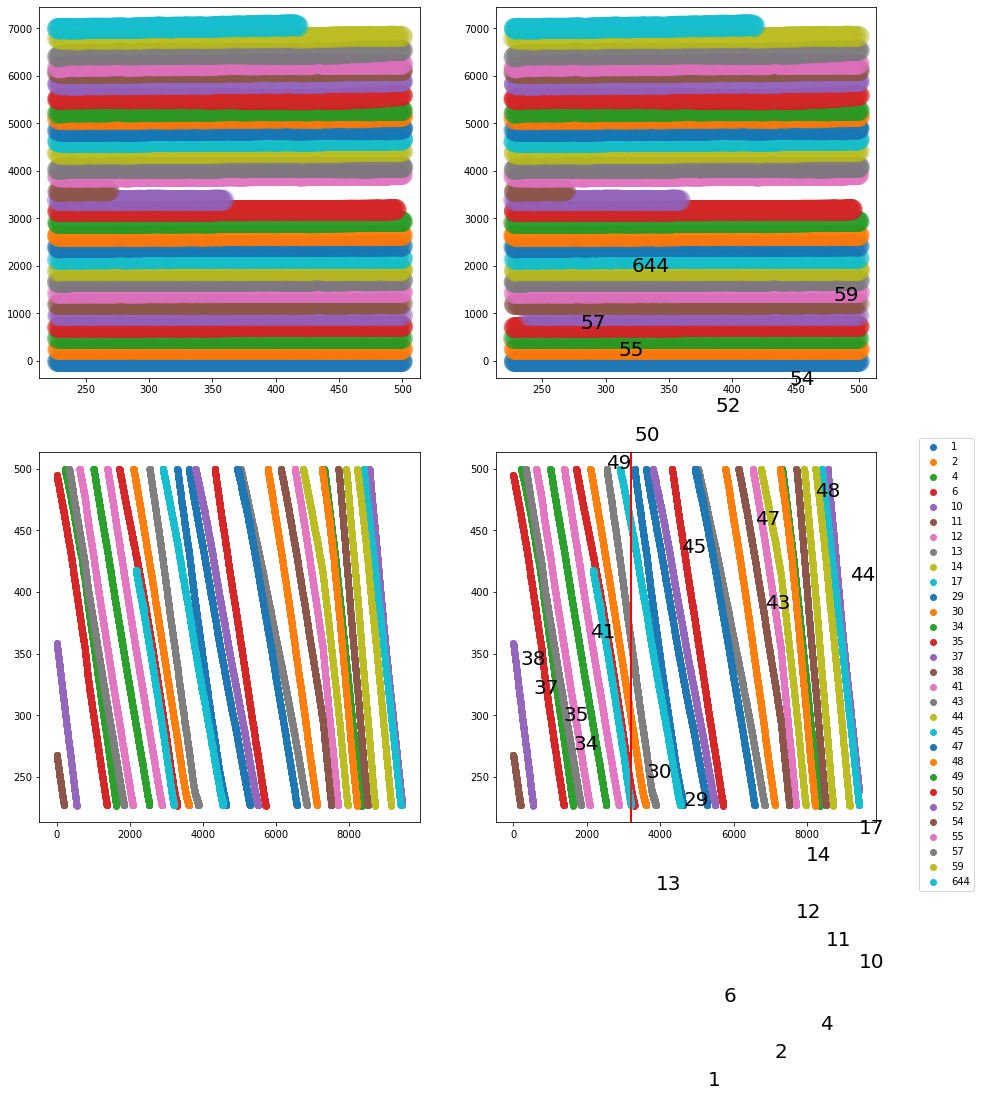

In [63]:
fig, (ax0,ax1) = plt.subplots(2,2, figsize = (15,15))

j = 0
for p,trj_p in df_x.groupby("particle"):
    
    ax0[0].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[0].plot(trj_p.frame, trj_p.x, 'o')
    j = j+1
    
j = 0
for p,trj_p in df_d.groupby("particle"):
    
    ax0[1].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[1].plot(trj_p.frame, trj_p.x, 'o', label = str(p))
    ax1[1].text(trj_p.frame.max(), trj_p.x.min()*0.1*j , s = str(p), size = 20)
    ax1[1].axvline(x=3200, color='r', linestyle='-')
    ax1[1].legend(bbox_to_anchor=(1.1, 1.05))


    print(str(p))

    

    j = j+1

In [45]:
#df_d.query('frame == 3200')

,frame,particle,y,x,bif


In [57]:
%%time
df_last = []

df_x = inter.query('x > '+str(x_bif)+'& x < 500')
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

for frame in df_d['frame'].unique(): # Do analysis frame by frame
    
    pairs = create_pairs(df_d, frame)
    mag = magnetization(pairs, frame)
    df_last.append(d(mag, 1, 1)) # I need to introduce the pix/um conversion.

    
last = pd.concat(df_last)    

CPU times: user 1min 55s, sys: 2.11 s, total: 1min 57s
Wall time: 1min 54s


In [58]:
check_analysis(trj, last)

Something was wrong during tracking or analysis. We detect N partcles and not N-1 pairs


In [61]:
len(last.particle.unique())

30

In [66]:
last.groupby(['p1','p2']).size(), len(last.groupby(['p1','p2']).size())

(p1   p2 
 1    52     2978
 2    54     1992
 4    11     1272
 6    47     1554
 11   59     1176
 12   14     1918
 13   45     1952
 14   4         8
      48     1422
 17   10     1716
 29   1      2030
 30   13     2162
 34   57     2592
 35   34     2316
      57        2
 37   35     1096
 38   37      404
 41   49     2146
 43   2      2148
 44   17     1522
 45   29     2496
 47   43     3092
 48   4      1794
 49   55     2306
 50   30     2404
 52   6      2366
 54   12     2004
 55   50      916
      644    1412
 57   41     2436
 59   44      978
 644  50     2082
 dtype: int64,
 32)

In [72]:
last1 = last1[last1.p1 != 55] # To drop unuseful particles

In [73]:
last1.groupby(['p1','p2']).size()

p1   p2
1    52    2978
2    54    1992
4    11    1272
6    47    1554
11   59    1176
12   14    1918
13   45    1952
17   10    1716
29   1     2030
30   13    2162
34   57    2592
37   35    1096
38   37     404
41   49    2146
43   2     2148
44   17    1522
45   29    2496
47   43    3092
48   4     1794
49   55    2306
50   30    2404
52   6     2366
54   12    2004
57   41    2436
59   44     978
644  50    2082
dtype: int64

In [58]:
last1 = last[(last.p1 != 13) & (last.p2 != 45)]
last1.groupby(['p1','p2']).size() 

p1    p2  
4     428     2140
5     9       1286
9     40      1588
10    1037    2166
22    35      1644
34    10      1082
35    4       1510
36    22       706
37    6       1690
40    34      1374
41    36      1098
428   5       1728
1037  13      1404
dtype: int64

In [84]:
last1 = last.query('p1 == 55 & p2 == 644')


In [78]:
last1.groupby(['p1','p2']).size() 

p1  p2
14  48    1422
dtype: int64

In [49]:
last.groupby(['p1','p2']).size() 

p1  p2
13  37    1914
dtype: int64

In [142]:
last1 = last[(last['p1'] == 14) & (last['p2'] == 1680)]
last1.groupby(['p1','p2']).size() 

p1    p2  
1399  1680    1266
dtype: int64

# Next step

Now I need to compute the main distance in the channel for pairs of particles and associate a magnetization value to this pair.

In [74]:
def distance_and_magnetization(df, x_bif):
    
    output = df.groupby(['p1','p2']).mean()
    output['d_err'] = df.groupby(['p1','p2']).distance.std()/np.sqrt(df.groupby(['p1','p2']).count()['distance'])
    
    return output

In [85]:
output = distance_and_magnetization(last1,x_bif)
output

,,frame,particle,y,x,magnetization,distance,d_err
p1,p2,,,,,,,
55,644,2526.5,349.5,241.169206,322.877244,1.0,67.744987,0.041342


In [86]:
output.to_csv('magnetization_'+name+'_3.dat', sep = '\t')